# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.405418,False,2.112417
1,-1.066220,False,1.173738
2,0.067600,True,4.971389
3,-1.769064,False,-1.132984
4,1.327620,False,1.080546
...,...,...,...
995,-1.939594,True,4.811588
996,-0.925954,True,5.042209
997,0.494302,True,5.216215
998,-0.283598,True,5.031695


<AxesSubplot:xlabel='v0'>

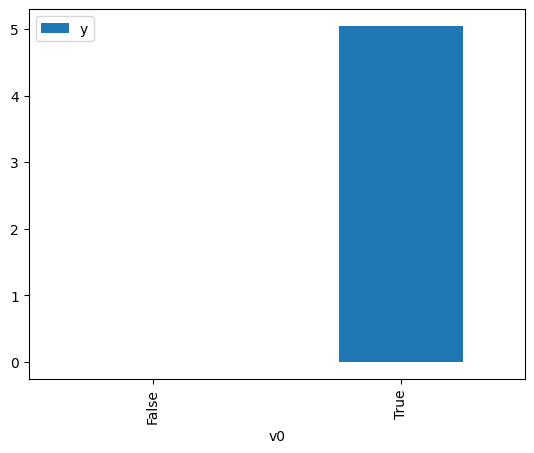

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

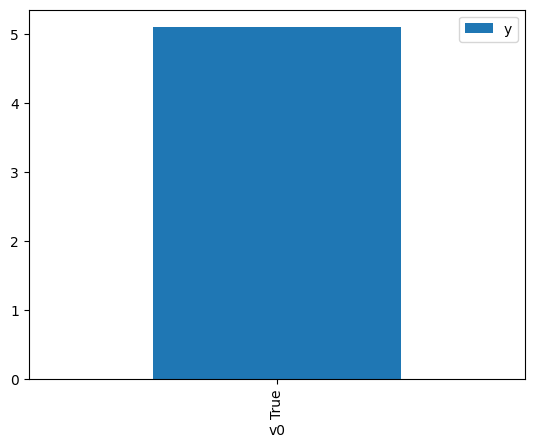

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.001025,False,-1.067650,0.500187,1.999251
1,-2.070262,False,1.256696,0.721828,1.385371
2,-0.405488,False,1.235605,0.546611,1.829453
3,-1.258449,False,-0.910764,0.641008,1.560042
4,-0.171460,False,-0.487344,0.519797,1.923829
...,...,...,...,...,...
995,1.421296,False,-0.174220,0.342050,2.923548
996,0.086384,False,-0.616153,0.490127,2.040289
997,-0.798327,False,0.444761,0.590945,1.692204
998,-0.162754,False,-1.585023,0.518796,1.927540


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.873926,True,5.026358,0.599199,1.668894
1,0.578638,True,4.688932,0.566150,1.766315
2,-1.218090,True,6.196127,0.363279,2.752702
3,0.326422,True,5.052820,0.537436,1.860685
4,-1.377334,True,4.958819,0.346494,2.886049
...,...,...,...,...,...
995,-1.153404,True,5.728081,0.370197,2.701267
996,1.787777,True,4.553946,0.694856,1.439147
997,-0.827863,True,4.576651,0.405771,2.464443
998,0.288580,True,3.054898,0.533102,1.875814


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              5894.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                        0.00
Time:                        08:06:34   Log-Likelihood:                         -1421.9
No. Observations:                1000   AIC:                                      2848.
Df Residuals:                     998   BIC:                                      2858.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0605      0.031     -1.925      0.054      -0.122       0.001
x2             5.0482      0.047    108.172      0.000       4.957       5.140
==============================================================================
Omnibus:                        2.093   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                1.916
Skew:                          -0.015   Prob(JB):                        0.384
Kurtosis:                       2.788   Cond. No.                         1.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""